In [1]:
## Import libraries 

import cv2
import numpy as np
import os
import pandas as pd

from tqdm import tqdm
from glob import glob

from sklearn.model_selection import train_test_split
from PIL import Image

from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, Callback

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
def create_dir(x):
    if not os.path.exists(x):
        os.makedirs(x)

save_path = "/kaggle/input/aerial-vegetation-1024/augmented1024"

# augment_data(images, masks, save_path, augment=True)

images = sorted(glob(os.path.join(save_path, "images/*")))
masks = sorted(glob(os.path.join(save_path, "masks/*")))
print(f"Total images:  {len(images)} - Total masks: {len(masks)}")

Total images:  924 - Total masks: 924


In [5]:
## Create dataframe

image_path =  os.path.join(save_path, "images/")
label_path = os.path.join(save_path, "masks/")

def create_dataframe(path):
    name = []
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            name.append(filename.split('.')[0])
    
    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df_images = create_dataframe(image_path)
df_masks = create_dataframe(label_path)
print('Total Images: ', len(df_images))
#print(df_images)

Total Images:  924


In [6]:
## Split data

X_trainval, X_test = train_test_split(df_images['id'], test_size=0.1, random_state=19) #split 10% data from dataset to create test data
X_train, X_val = train_test_split(X_trainval, test_size=0.2, random_state=19) #split 20% data from remaining data to create validation data

print(f"Train Size : {len(X_train)} images")
print(f"Val Size   :  {len(X_val)} images")
print(f"Test Size  :  {len(X_test)} images")

y_train = X_train #the same values for images (X) and labels (y)
y_test = X_test
y_val = X_val

img_train = [os.path.join(image_path, f"{name}.JPG") for name in X_train]
mask_train = [os.path.join(label_path, f"{name}.png") for name in y_train]
img_val = [os.path.join(image_path, f"{name}.JPG") for name in X_val]
mask_val = [os.path.join(label_path, f"{name}.png") for name in y_val]
img_test = [os.path.join(image_path, f"{name}.JPG") for name in X_test]
mask_test = [os.path.join(label_path, f"{name}.png") for name in y_test]

Train Size : 664 images
Val Size   :  167 images
Test Size  :  93 images


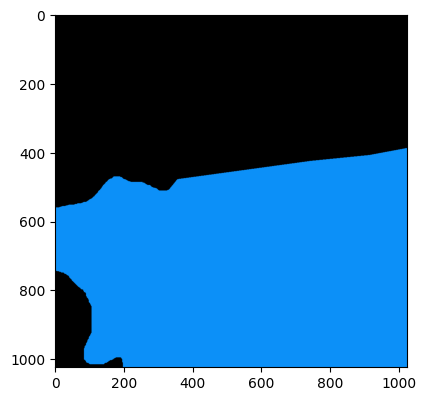

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3]
 [0 0 3 0 0 0 3 3 3 3 3 3 3 3 3 3]
 [0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
 [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
 [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
 [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
 [0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
 [0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
 [0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
 [0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]]


In [7]:
import random as rnd
import cv2
from pylab import *

n = rnd.randint(0, len(img_train))
plt.figure(figsize=(10, 10))
plt.subplot(1,2,1)
y = cv2.imread(mask_train[n])
y2 = cv2.cvtColor(y, cv2.COLOR_BGR2RGB)
imshow(y2)
plt.show()

x = cv2.imread(mask_train[n], cv2.IMREAD_GRAYSCALE)
x[x == 158] = 1 
x[x == 135] = 2 
x[x == 116] = 3
x[x > 3] = 0
x = cv2.resize(x, (16, 16))
print(x) 

In [8]:
## Define U-Net Model
## In order to minimize the dimension of the model, it is possible to reduce the number of the filters for each layer.
## To do this, scale by a factor 2 the variables filters_x and filters_b.

# Function for creating one convolution block
# Each block contains two 3x3 convolution layer + ReLU activation function with Batch normalization and one 2x2 Maxpooling layer
def conv_block(inputs, filters, pool=True):
    x = Conv2D(filters, 3, padding='same')(inputs) #convolution (Downsampling) layer
    x = BatchNormalization()(x) #Batch normalization
    x = Activation('relu')(x) #ReLU (Rectified Linear Unit) Activation Function
    
    x = Conv2D(filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    if pool == True:
        p = MaxPool2D((2,2))(x) #Maxpooling layer
        return x, p # x is filters and p is output feature map obtained after maxpooling
    else:
        return x
    
    
def build_unet(shape, num_classes):   # this function is used to create unet architecture using conv_block function
    inputs = Input(shape)
    
    filters_x = [16,32,48,64,64,48,32,16]
    filters_b = [128] 

    # Encoder : Encoder path consist of 4 blocks
    # Encoder path is used to capture context (feature map) of input image in order to do segmentation
    x1, p1 = conv_block(inputs, filters_x[0], pool=True)
    x2, p2 = conv_block(p1, filters_x[1], pool=True)
    x3, p3 = conv_block(p2, filters_x[2], pool=True)
    x4, p4 = conv_block(p3, filters_x[3], pool=True)    
    
    # Bridge
    b1 = conv_block(p4, filters_b[0], pool=False) #Bridge is used to pass context from Encoder layer to Decoder layer
    
    # Decoder : Decoder path consist of 4 blocks
    # Decoder path is used to reconstruct segmentation image from contracted image obtained from encoder path
    u1 = UpSampling2D((2,2), interpolation='bilinear')(b1) #DeConvolution (upsampling) layer for upsizing image.
    c1 = Concatenate()([u1, x4]) #Concatenation layer - It concatenates current image with corresponding image from encoder path to increase pixel precision.
    x5 = conv_block(c1, filters_x[4], pool=False) #convolution layer with no pooling
    
    u2 = UpSampling2D((2,2), interpolation='bilinear')(x5)
    c2 = Concatenate()([u2, x3])
    x6 = conv_block(c2, filters_x[5], pool=False)
    
    u3 = UpSampling2D((2,2), interpolation='bilinear')(x6)
    c3 = Concatenate()([u3, x2])
    x7 = conv_block(c3, filters_x[6], pool=False)
    
    u4 = UpSampling2D((2,2), interpolation='bilinear')(x7)
    c4 = Concatenate()([u4, x1])
    x8 = conv_block(c4, filters_x[7], pool=False)
    
    # Output Layer
    output = Conv2D(num_classes, 1, padding='same', activation='softmax')(x8) # Output layer to create segmentation image of same size. 
    # 'softmax' activation function is used to classify pixels into different classes

    return Model(inputs, output)

In [9]:
## Define the resolution of the images and the number of classes

H = 1024   
W = 1024 
num_classes = 4
#calling function to build model
model = build_unet((W, H, 3), num_classes)  

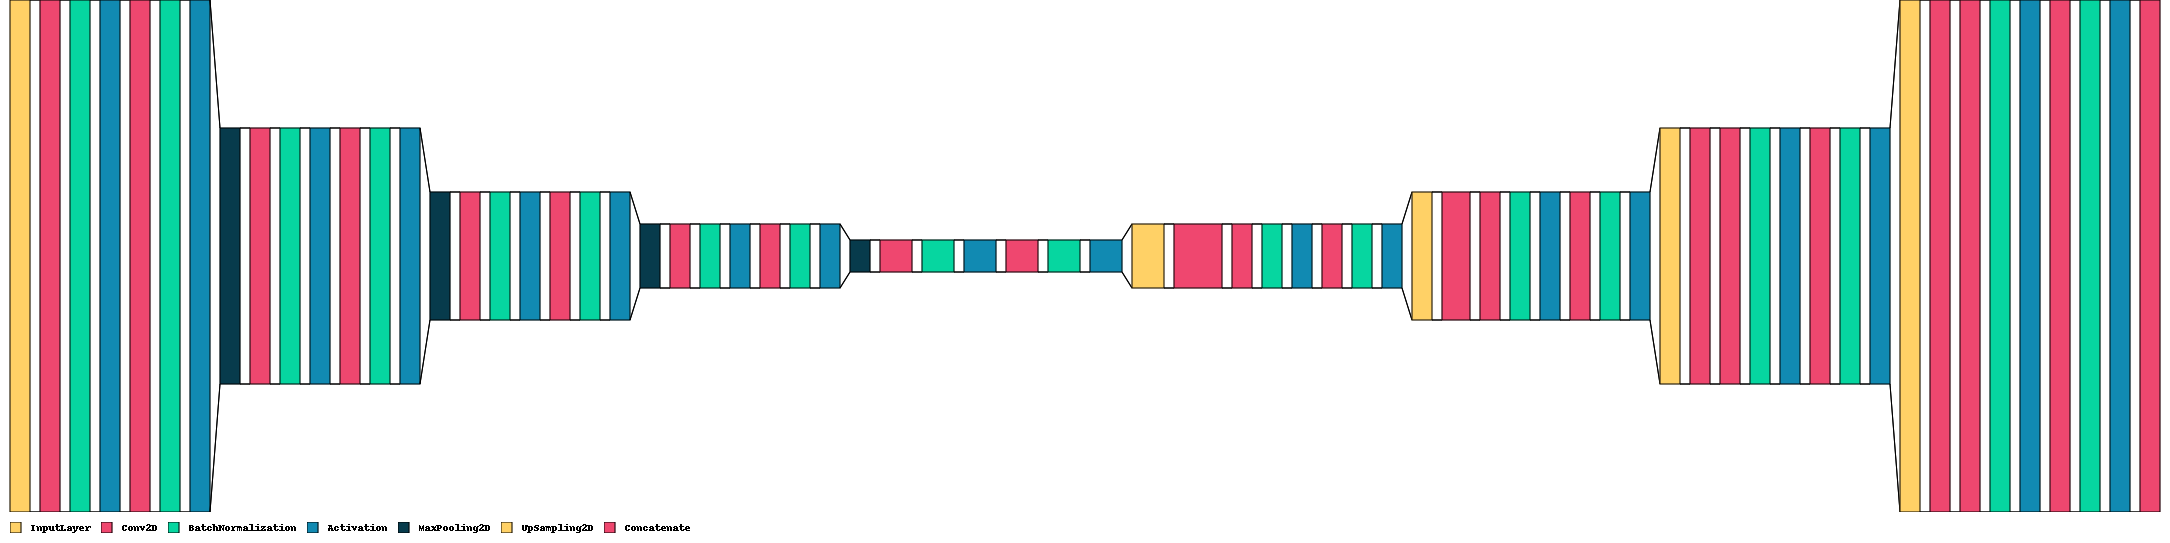

In [36]:
# !pip install visualkeras
import visualkeras

visualkeras.layered_view(model,legend=True, draw_volume=False, scale_xy=0.5, scale_z=0.25, max_z=1000)
# visualkeras.layered_view(model, to_file='output.png').show() # write and show

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1024, 1024,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, 1024, 1024,   448         ['input_1[0][0]']                
                                16)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 1024, 1024,   64         ['conv2d[0][0]']                 
 alization)                     16)                                                           

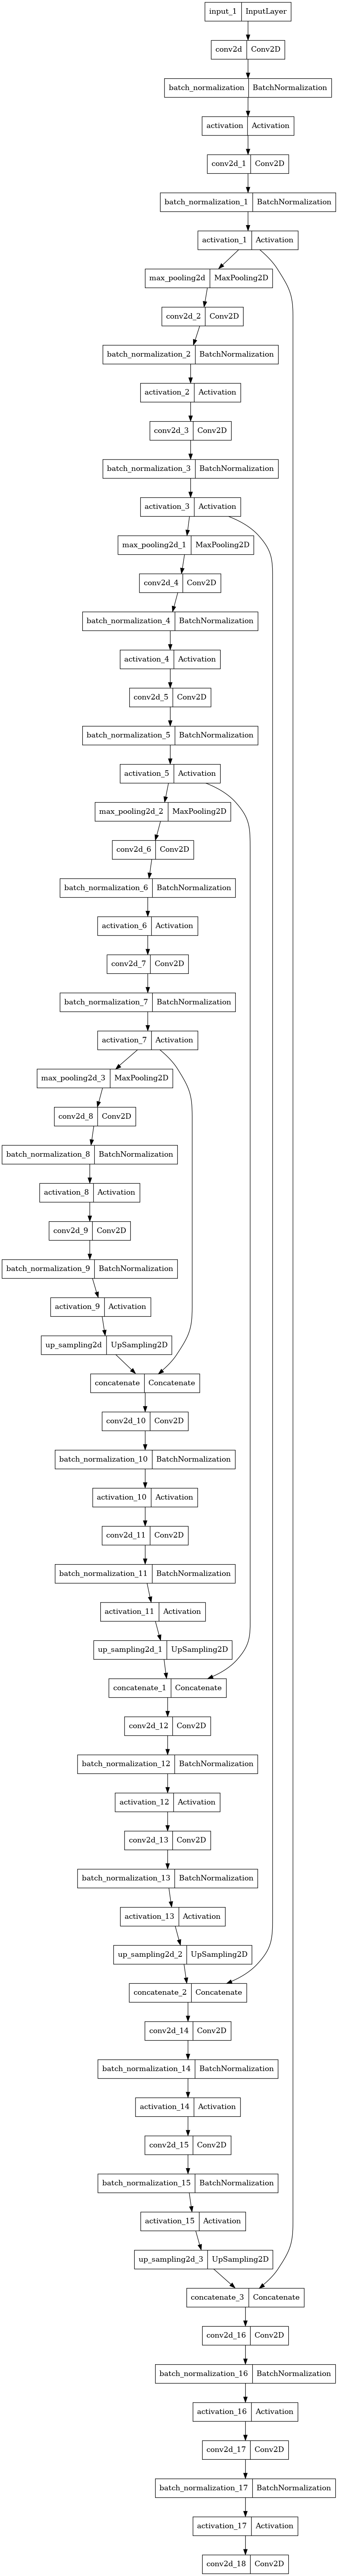

In [37]:
## Show the summary of the U-Net model and its diagram

model.summary()
print("Total number of layers : ", len(model.layers))
plot_model(model,to_file='aerial-unet-diagram.png') #plot flow diagram

In [38]:
## Dataset Pipeline used for training the model

def read_image(x):
    x = cv2.imread(x, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x/255.0
    x = x.astype(np.float32)
    return x


def read_mask(x):
    x = cv2.imread(x, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (W, H))
    x[x == 158] = 1 
    x[x == 135] = 2 
    x[x == 116] = 3
    x[x > 3] = 0
    x = x.astype(np.int32)
    return x


def tf_dataset(x,y, batch=4):
    dataset = tf.data.Dataset.from_tensor_slices((x,y))
    dataset = dataset.shuffle(buffer_size=500)
    dataset = dataset.map(preprocess)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    dataset = dataset.prefetch(2)
    return dataset
    

def preprocess(x,y):
    def f(x,y):
        x = x.decode()
        y = y.decode()
        image = read_image(x)
        mask = read_mask(y)
        return image, mask
    
    image, mask = tf.numpy_function(f,[x,y],[tf.float32, tf.int32])
    mask = tf.one_hot(mask, num_classes, dtype=tf.int32)
    image.set_shape([H, W, 3])    # In the Images, number of channels = 3. 
    mask.set_shape([H, W, num_classes])    # In the Masks, number of channels = number of classes. 
    return image, mask

**Train Model:**

In [43]:
## Train the model

# Seeding
np.random.seed(42)
tf.random.set_seed(42)

# Hyperparameters
shape = (H, W, 3) 
num_classes = 4  # number of classes in image
lr = 1e-4 #learning rate 
batch_size = 8 #entire dataset is divided into batches 
epochs = 50 #when  entire dataset is passed through architecture its 1 epoch

# Model
model = build_unet(shape, num_classes)

#compiling model | loss = loss detection function, optimizer = optimizer for updating filters
model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(lr), metrics=['accuracy']) 

train_dataset = tf_dataset(img_train, mask_train, batch = batch_size) #creating training dataset
valid_dataset = tf_dataset(img_val, mask_val, batch = batch_size) #creating validation dataset

train_steps = len(img_train)//batch_size  #training steps is also called iteration
valid_steps = len(img_val)//batch_size # vaidation steps

callbacks = [
    ModelCheckpoint("model.h5", verbose=1, save_best_model=True), #save model with best accuracy
    ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.1, verbose=1, min_lr=1e-6), #reduce learning rate if loss doesn't decrease after 3 epochs
    EarlyStopping(monitor='val_loss', patience=10, verbose=1) #stop training if loss doesn't decrease after 5 epochs
]

#model.fit function is used to train model
model.fit(train_dataset,
          steps_per_epoch=train_steps,
          validation_data=valid_dataset,
          validation_steps=valid_steps,
          epochs=epochs,
          callbacks=callbacks
         )

Epoch 1/50
83/83 [==============================] - ETA: 0s - loss: 0.7884 - accuracy: 0.7513
Epoch 1: saving model to model.h5
83/83 [==============================] - 80s 825ms/step - loss: 0.7884 - accuracy: 0.7513 - val_loss: 1.4012 - val_accuracy: 0.4227 - lr: 1.0000e-04
Epoch 2/50
83/83 [==============================] - ETA: 0s - loss: 0.5805 - accuracy: 0.8468
Epoch 2: saving model to model.h5
83/83 [==============================] - 67s 811ms/step - loss: 0.5805 - accuracy: 0.8468 - val_loss: 1.7812 - val_accuracy: 0.4220 - lr: 1.0000e-04
Epoch 3/50
83/83 [==============================] - ETA: 0s - loss: 0.5211 - accuracy: 0.8638
Epoch 3: saving model to model.h5
83/83 [==============================] - 67s 813ms/step - loss: 0.5211 - accuracy: 0.8638 - val_loss: 2.1188 - val_accuracy: 0.4294 - lr: 1.0000e-04
Epoch 4/50
83/83 [==============================] - ETA: 0s - loss: 0.4627 - accuracy: 0.8827
Epoch 4: saving model to model.h5

Epoch 4: ReduceLROnPlateau reducing lear

In [44]:
model.save('aerial-unet.h5')

In [ ]:
!pip install matplotlib==3.3.4
import matplotlib.pyplot as plt

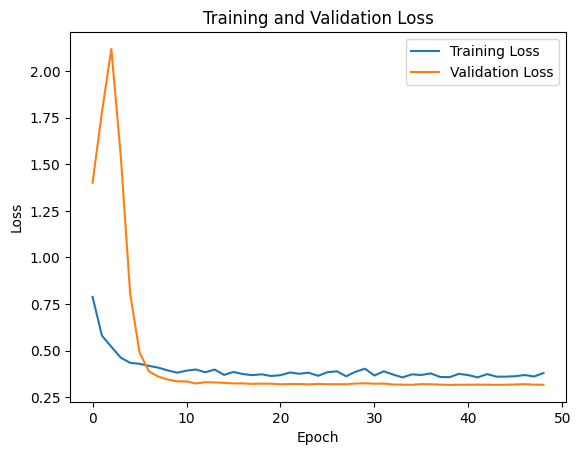

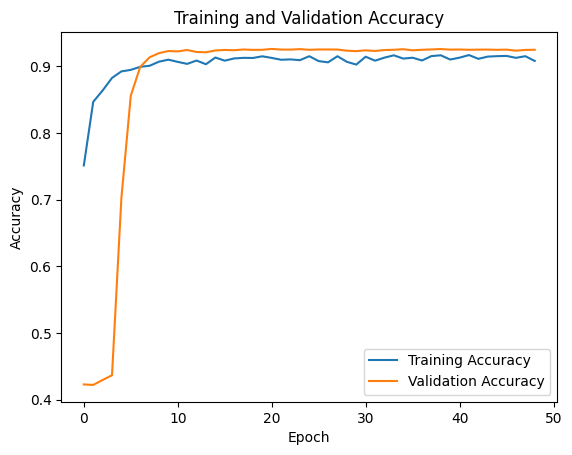

In [45]:
# plot the training loss
plt.plot(model.history.history['loss'], label='Training Loss')

# plot the validation loss if available
if 'val_loss' in model.history.history:
    plt.plot(model.history.history['val_loss'], label='Validation Loss')

# set the axis labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')

# display the legend
plt.legend()

# save the plot as EPS and PNG file
plt.savefig('loss_aerial-unet.eps', format='eps', dpi=1200)
plt.savefig('loss_aerial-unet.png', dpi=1200)

# show the plot
plt.show()

# plot the training accuracy
plt.plot(model.history.history['accuracy'], label='Training Accuracy')

# plot the validation accuracy if available
if 'val_accuracy' in model.history.history:
    plt.plot(model.history.history['val_accuracy'], label='Validation Accuracy')

# set the axis labels and title
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

# display the legend
plt.legend()

# save the plot as EPS and PNG file
plt.savefig('accuracy_aerial-unet.eps', format='eps', dpi=1200)
plt.savefig('accuracy_aerial-unet.png', dpi=1200)

# show the plot
plt.show()


In [46]:
import imghdr
create_dir('/kaggle/working/output')
create_dir('/kaggle/working/prediction')
create_dir('/kaggle/working/img_test')
create_dir('/kaggle/working/mask_test')

# Define the paths to the model file
model_path = "/kaggle/working/model.h5"

# Define the image size and number of classes
img_size = (1024, 1024)
num_classes = 4  # 2 objects + background

# Load the model
model = tf.keras.models.load_model(model_path)

In [47]:
# Save Test Data to seperate folders
import os
import shutil

# Path of the source folder containing files to copy
source_folder_path = "/kaggle/input/aerial-vegetation-1024/augmented1024/images"
source_folder_path2 = "/kaggle/input/aerial-vegetation-1024/augmented1024/masks"
# Path of the destination folder where files will be copied
destination_folder_path = "/kaggle/working/img_test"
destination_folder_path2 = "/kaggle/working/mask_test"

# List of filenames to copy
filenames_to_copy = [os.path.basename(file_path) for file_path in img_test] #test images
filenames_to_copy2 = [os.path.basename(file_path) for file_path in mask_test] #test masks

# Iterate through all the files in the source folder
for filename in os.listdir(source_folder_path):
    # Check if the file is in the filenames to copy list
    if filename in filenames_to_copy:
        # If it is, construct the paths to the source and destination files
        source_file_path = os.path.join(source_folder_path, filename)
        destination_file_path = os.path.join(destination_folder_path, filename)
        # Copy the file to the destination folder
        shutil.copyfile(source_file_path, destination_file_path)
#         print(f"File {filename} has been copied to the destination folder.")
        
for filename in os.listdir(source_folder_path2):
    # Check if the file is in the filenames to copy list
    if filename in filenames_to_copy2:
        # If it is, construct the paths to the source and destination files
        source_file_path = os.path.join(source_folder_path2, filename)
        destination_file_path = os.path.join(destination_folder_path2, filename)
        # Copy the file to the destination folder
        shutil.copyfile(source_file_path, destination_file_path)
        print(f"File {filename} has been copied to the destination folder.")


File 0150_3.png has been copied to the destination folder.
File 0216_0.png has been copied to the destination folder.
File 0262_1.png has been copied to the destination folder.
File 0136_0.png has been copied to the destination folder.
File 0226_3.png has been copied to the destination folder.
File 0248_3.png has been copied to the destination folder.
File 0214_5.png has been copied to the destination folder.
File 0117_3.png has been copied to the destination folder.
File 0143_1.png has been copied to the destination folder.
File 0138_1.png has been copied to the destination folder.
File 0172_0.png has been copied to the destination folder.
File 0247_2.png has been copied to the destination folder.
File 0169_5.png has been copied to the destination folder.
File 0167_3.png has been copied to the destination folder.
File 0144_0.png has been copied to the destination folder.
File 0155_4.png has been copied to the destination folder.
File 0003_5.png has been copied to the destination folde

In [48]:
# prediction in test data
# Define the input and output directory to save the predicted masks
output_dir = "/kaggle/working/output"
input_dir = "/kaggle/working/img_test"

# Loop through each input image in the input directory
for filename in os.listdir(input_dir):
    # Load the input image and preprocess it
    img = cv2.imread(os.path.join(input_dir, filename))
    img = cv2.resize(img, img_size)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)

    # Perform prediction using the loaded model
    pred = model.predict(img)[0]
    pred = np.argmax(pred, axis=-1)

    # Save the predicted mask to the output directory
    mask = np.zeros((img_size[0], img_size[1], 3), dtype=np.int32)
    mask[pred == 0] = [0, 0, 0]  # Background
    mask[pred == 1] = [0, 255, 75]  # Object 1 (BGR)
    mask[pred == 2] = [255, 52, 255]  # Object 2 
    mask[pred == 3] = [248, 144, 12]  # Object 2 
    output_filename = os.path.join(output_dir, os.path.splitext(filename)[0] + ".png")
    cv2.imwrite(output_filename, mask)


1/1 [==============================] - 0s 29ms/step


In [49]:
# Concatenate Image, Mask and Prediction
# Define the paths to the predicted, ground truth, and input image directories
pred_dir = "/kaggle/working/output"
gt_dir = "/kaggle/working/mask_test"
input_dir = "/kaggle/working/img_test"

# Define the output directory to save the concatenated images
output_dir = "/kaggle/working/prediction"

# Define the border color and width
border_color = (255, 255, 255)  # white
border_width = 5

# Loop through each input image in the input image directory
for filename in os.listdir(input_dir):
    input_path = os.path.join(input_dir, filename)

    # Extract the filename without extension
    file_prefix = os.path.splitext(filename)[0]

    # Construct the paths to the predicted and ground truth images
    pred_path = os.path.join(pred_dir, file_prefix + ".png")
    gt_path = os.path.join(gt_dir, file_prefix + ".png")

    # Load the predicted, ground truth, and input images
    pred_img = cv2.imread(pred_path, cv2.IMREAD_UNCHANGED)
    pred_img = cv2.resize(pred_img, (1024, 1024))
    gt_img = cv2.imread(gt_path, cv2.IMREAD_UNCHANGED)
    input_img = cv2.imread(input_path)

    # Check that all images have nonzero dimensions
    if pred_img.size == 0 or gt_img.size == 0 or input_img.size == 0:
        print(f"Skipping {filename} due to zero-dimensional array")
        continue

    # Create a blank border image and concatenate it with the images
    border_img = np.ones((input_img.shape[0], border_width, 3), dtype=np.uint8) * border_color
    concat_img = np.concatenate((input_img, border_img, gt_img, border_img, pred_img), axis=1)

    # Save the concatenated image to the output directory
    output_filename = os.path.join(output_dir, filename)
    cv2.imwrite(output_filename, concat_img)

In [50]:
!zip -r /kaggle/working/aerial-unet.zip /kaggle/working/

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/accuracy_aerial-unet.png (deflated 37%)
  adding: kaggle/working/model.h5 (deflated 12%)
  adding: kaggle/working/aerial-unet.h5 (deflated 12%)
  adding: kaggle/working/accuracy_aerial-unet.eps (deflated 66%)
  adding: kaggle/working/mask_test/ (stored 0%)
  adding: kaggle/working/mask_test/0196_5.png (deflated 9%)
  adding: kaggle/working/mask_test/0155_4.png (deflated 13%)
  adding: kaggle/working/mask_test/0136_3.png (deflated 13%)
  adding: kaggle/working/mask_test/0260_1.png (deflated 60%)
  adding: kaggle/working/mask_test/0206_5.png (deflated 10%)
  adding: kaggle/working/mask_test/0143_3.png (deflated 10%)
  adding: kaggle/working/mask_test/0172_0.png (deflated 11%)
  adding: kaggle/working/mask_test/0024_3.png (deflated 32%)
  adding: kaggle/working/mask_test/0129_5.png (deflated 8%)
  adding: kaggle/working/mask_test/0143_1.png (deflated 28%)
  adding: kaggle/working/mask_test/0167_3.png (deflated 13%)
  adding: k

In [31]:
# !rm -rf /kaggle/working/aerial-unet2-accu.eps